*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


Tutorial reference for model and code:

https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [63]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.11.0-dev20221007


In [64]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2022-10-07 15:56:39--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv.4’

train-data.tsv.4    100%[===================>] 349.84K  --.-KB/s    in 0.04s   

2022-10-07 15:56:39 (8.80 MB/s) - ‘train-data.tsv.4’ saved [358233/358233]

--2022-10-07 15:56:39--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv.4’

valid-data.tsv.4    100%[========

In [65]:
train_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
train_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [66]:
test_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
test_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [67]:
train_df["type"] = pd.factorize(train_df["type"])[0]
test_df["type"] = pd.factorize(test_df["type"])[0]

In [68]:
train_labels =  train_df["type"].values
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["msg"].values, train_labels)
)

test_labels =  test_df["type"].values
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["msg"].values, test_labels)
)
test_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [69]:
#Shuffle the data and create batches to better fit the model
BUFFER_SIZE = 100
BATCH_SIZE = 32
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Raw text by tfds needs to be processed before it can be used in a model.

The TextVectorisation layer was used which maps text features to integer sequences.

In [70]:
vec = TextVectorization(
    output_mode='int',
    max_tokens=1000,
    output_sequence_length=1000,
)

#adapt method sets the layer's vocabulary
vec.adapt(train_ds.map(lambda text, label: text))

In [71]:
# First 20 tokens to see if our vectorisation is working properly

vocab = np.array(vec.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'to', 'you', 'a', 'the', 'u', 'and', 'is', 'in',
       'me', 'my', 'your', 'for', 'have', 'it', 'of', 'call', 'that'],
      dtype='<U16')

Create the model

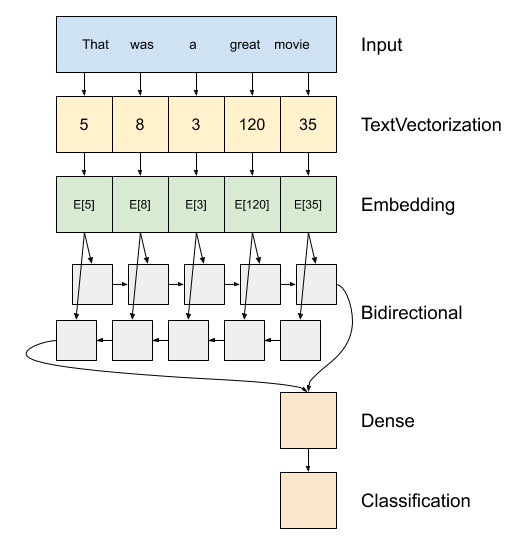


In [72]:
model = tf.keras.Sequential([
    vec,
    tf.keras.layers.Embedding(
        len(vec.get_vocabulary()),
        64,
        mask_zero=True,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

In [73]:
# Train model using the data set

history = model.fit(
    train_ds,
    validation_data=test_ds,
    validation_steps=30,
    epochs=10,
)

Epoch 1/10
44/44 [==============================] - 175s 3s/step - loss: 0.6749 - accuracy: 0.8657 - val_loss: 0.6500 - val_accuracy: 0.8604
Epoch 2/10
44/44 [==============================] - 149s 3s/step - loss: 0.6010 - accuracy: 0.8657 - val_loss: 0.5438 - val_accuracy: 0.8604
Epoch 3/10
44/44 [==============================] - 141s 3s/step - loss: 0.5075 - accuracy: 0.8657 - val_loss: 0.4704 - val_accuracy: 0.8604
Epoch 4/10
44/44 [==============================] - 140s 3s/step - loss: 0.4312 - accuracy: 0.8657 - val_loss: 0.3965 - val_accuracy: 0.8604
Epoch 5/10
44/44 [==============================] - 140s 3s/step - loss: 0.3425 - accuracy: 0.8657 - val_loss: 0.2819 - val_accuracy: 0.8604
Epoch 6/10
44/44 [==============================] - 140s 3s/step - loss: 0.2214 - accuracy: 0.8657 - val_loss: 0.1721 - val_accuracy: 0.8604
Epoch 7/10
44/44 [==============================] - 139s 3s/step - loss: 0.1457 - accuracy: 0.8829 - val_loss: 0.1190 - val_accuracy: 0.9625
Epoch 8/10
44

In [74]:
test_loss, test_acc = model.evaluate(test_ds)

44/44 [==============================] - 23s 529ms/step - loss: 0.0418 - accuracy: 0.9892


In [75]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.04181535169482231
Test Accuracy: 0.9892241358757019


In [76]:
def plot_graphs(h, metric):
    plt.plot(h.history[metric])
    plt.plot(h.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

(0.0, 0.706459047831595)

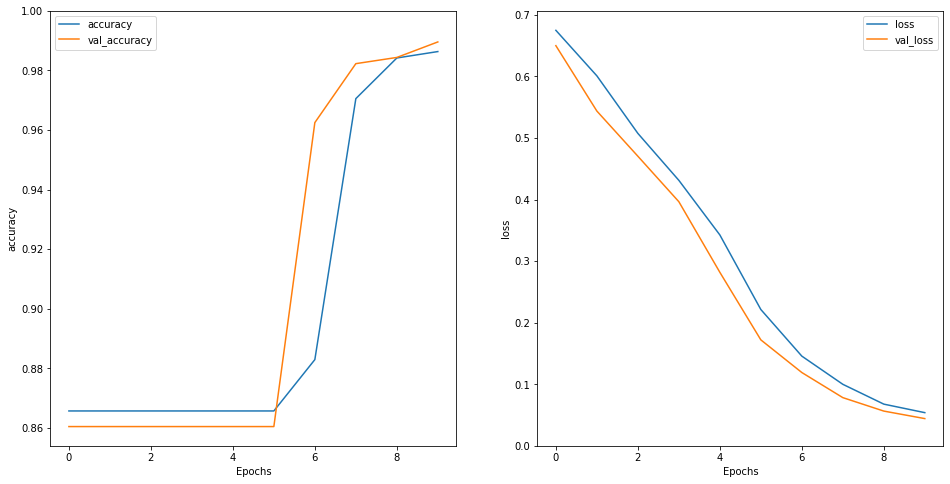

In [77]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [80]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  p = model.predict([pred_text])[0]
  print(p)
  return (p[0], ("ham" if p<0.0 else "spam"))
  

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 0s 240ms/step
[-4.2658587]
(-4.2658587, 'ham')


In [81]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 225ms/step
[-4.2658587]
1/1 [==============================] - 0s 231ms/step
[0.4037582]
1/1 [==============================] - 0s 244ms/step
[-9.862889]
1/1 [==============================] - 0s 254ms/step
[0.10833851]
1/1 [==============================] - 0s 229ms/step
[1.7584932]
1/1 [==============================] - 0s 230ms/step
[-8.010811]
1/1 [==============================] - 0s 229ms/step
[-9.215874]
You passed the challenge. Great job!
